In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, sparse
from itertools import product
import warnings
%matplotlib inline

# Question 2 - Hough Transform

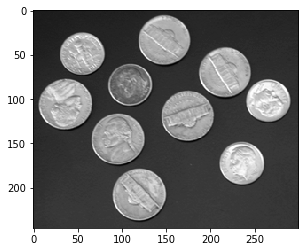

In [2]:
# Step 0: Read the image in grayscale
img = cv2.imread('coins.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

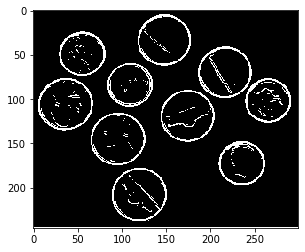

In [3]:
def edgeDetector(image, threshold=100, epsilon=1e-5):
    '''
    This function should get as input the grayscale 'image' and any additional
    parameters you need, and return 'edge_map': a binary image (same shape as 'image')
    with a value of 1 in each detected edge pixel and a value of zero otherwise.
    ''' 
    # sobel 3*3 kernels: smoothing and first derivative
    Kx = np.array([
        [1, 0, -1],
        [2, 0, -2],
        [1, 0, -1]
    ])
    Ky = np.array([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]
    ])
    # gradients
    Gx = signal.convolve2d(image, Kx, mode='same')
    Gy = signal.convolve2d(image, Ky, mode='same')
    G = np.sqrt(Gx**2 + Gy**2)
    # edges: values are 0 or 1
    G *= 255 / G.max() # normalizing the gradients to be in the range [0,255]
    edge_map = (G>threshold).astype(float)
    # directions: the +epsilon is used to avoid division in zero, values are in the range [-pi/2, pi/2]
    direction_map = -np.arctan(Gy/(Gx+epsilon))
    
    return edge_map, direction_map

# Step 1: Produce an edge map from the image using an edge detector
edges, directions = edgeDetector(img, threshold=60)
_=plt.imshow(edges, cmap='gray')

In [4]:
def HoughCircles(edge_map, direction_map, min_r=15, max_r=40, n_r=100, n_x=100, n_y=100, 
                 maxima_kernel_size=3, maxima_constant=30):
    '''
    This function should get as input binary edge map and any additional
    parameters needed to compute the Hough space and to find the local maximums.
    It should first compute the Hough space, i.e. the votes of each edge pixel
    for all the relevant circles passing by it. Then, it should detect the local 
    maximum points which are equivalent to detecting the circles in the image.
    The algorithm should return the following variables:
    circles_center: a list of the center coordinates of all the detected circles;
                  Each center coordinates are represented as tuples of two values (X_coordinate, Y_coordinate).
    circles_radius: a list of the radius of all the detected circles. 
                  circles_radius[0] should correspond to the same circle saved in
                  circles_center[0].
    Note: you may add any additional input and\or output parameters to this algorithm,
    but you must explain each of them in the atached pdf. 
    '''
    #======= Replace with relevant code
    # parameters’ ranges
    Rs = np.linspace(min_r, max_r, n_r)
    xmax, ymax = edge_map.shape
    Cxs = np.linspace(0, xmax, n_x)
    Cys = np.linspace(0, ymax, n_y)
    # array of coordinates for each edge point
    edge_coords = np.argwhere(edges==1) #shape(n_edges, 2)
    n_edges = edge_coords.shape[0]
    # array of cartesian coordinates for each edge point
    edge_coords_cart = np.concatenate((edge_coords, np.ones((n_edges,1))), axis=1) #shape(n_edges, 3)
    # array of angles (in radians) for each edge point
    thetas = directions[tuple(edge_coords.T)] #shape(n_edges,)
    # diagonal #1 in the form: 
    #[0,r^1*cos(theta^1),0, ...,0,r^(n_r)*cos(theta^1), 0,r^1*cos(theta^2),0, ...,  0,r^(n_r)*cos(theta^2),0, ...]
    diag1 = np.kron(np.kron(np.cos(thetas), Rs), np.array([0,1,0])) #shape (n_edges*3*n_r,)
    # diagonal #2 in the form: 
    #[-r^1*sin(theta^1),0,0,...,-r^(n_r)*sin(theta^1),0,0, -r^1*sin(theta^2),0,0,..., -r^(n_r)*sin(theta^2),0,0,...]
    diag2 = -np.kron(np.kron(np.sin(thetas), Rs), np.array([1,0,0])) #shape (n_edges*3*n_r,)
    # the system of equations to solve Ax=b
    diagonals = [np.ones(3*n_r*n_edges), diag1[:-1], diag2[:-2]]
    A = sparse.diags(diagonals, [0, 1, 2], format='csr') #shape(3*n_r*n_edges, 3*n_r*n_edges)
    b = np.tile(edge_coords_cart, n_r).flatten() #shape (n_edges*3*n_r,)
    # 1D array tiled array of votes for cartesian centers [Cx_i, Cy_i, 1] * n_edges*3*n_r
    raw_centers_cart = sparse.linalg.spsolve(A, b) #shape (n_edges*3*n_r,)
    # polar centers
    raw_centers = raw_centers_cart.reshape(n_edges, n_r, 3)[:,:,:2] #shape (n_edges, n_r, 2)
    # array of #n_edges*n_r rows, each with 1 vote [Cx, Cy, r]
    tiled_Rs = np.tile(Rs, n_edges).reshape(n_edges,n_r,1) #shape (n_edges, n_r, 1)
    all_votes = np.concatenate((raw_centers, tiled_Rs), axis=2).reshape(n_edges*n_r,3) #shape (n_edges*n_r,3)
    # 3D histogram of the votes
    hist_votes, bins_edges = np.histogramdd(all_votes, bins=(Cxs, Cys, Rs)) #shape (n_x,n_y,n_r)
    # finding local maxima by subtracting the average neighborhood from each point (minus the maxima_constant)
    n = maxima_kernel_size
    K = -np.ones((n,n,n)) / (n**3 - 1)
    K[n//2,n//2,n//2] = 1
    threshold = signal.convolve(hist_votes, K, mode='same') - maxima_constant #shape (n_x,n_y,n_r)
    # store results
    circles_center = []
    circles_radius = []
    circles = []
    indecies = np.array(list(product(range(threshold.shape[0]), range(threshold.shape[1]), range(threshold.shape[2]))))
    ordered_indecies = indecies[np.argsort(threshold, axis=None)[::-1]]
    for Cx_i, Cy_j, R_k in ordered_indecies:
        if threshold[Cx_i, Cy_j, R_k] <= 0:
            break
        Cx, Cy, R = bins_edges[0][Cx_i], bins_edges[1][Cy_j], bins_edges[2][R_k]
        # check if new point is outside of known circles
        if all([np.sqrt((Cx-x)**2 + (Cy-y)**2) > r for x, y, r in circles]):
            circles.append((Cx, Cy, R))
            circles_center.append((Cx, Cy))
            circles_radius.append(R)
    #========
    return circles_center, circles_radius

# Step 2: Detect circles in the image using Hough transform
circles_center, circles_radius = HoughCircles(edges, directions, maxima_constant=40)

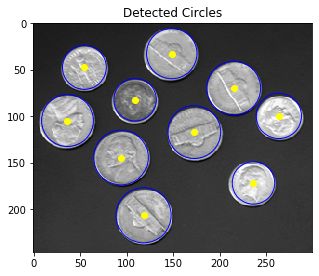

In [5]:
def plotCircles(image,circles_center,circles_radius):
    '''
    This function should plot the detected circles.
    It should draw the circumference of the circles in blue and mark the center 
    of the circles by a small yellow point.
    '''
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(image, cmap="gray")
    ax.title.set_text("Detected Circles")

    # Replace with code to mark the center of the circles by a yellow point
    ax.plot([tpl[1] for tpl in circles_center],[tpl[0] for tpl in circles_center], 'o', color='yellow')

    # Replace with code to draw the circumference of the circles in blue
    for center_coordinates, radius in zip(circles_center,circles_radius):
        x, y = center_coordinates
        circ = plt.Circle((y, x), radius, color='blue', fill=False)
        ax.add_artist(circ)
  
 
# Step 3: Plot the detected circles on top of the original coins image
plotCircles(img,circles_center,circles_radius)

# Question 4 - Segmentation and Relaxation Labeling

In [6]:
def set_initial_confidence(img, n_L=10):
    n_rows, n_cols = img.shape
    # first derivative kernels
    Kx = np.array([[-1, 0, 1]]) #shape (1,3)
    Ky = np.array([[-1], [0], [1]]) #shape (3,1)
    # gradients
    Gx = signal.convolve2d(img, Kx, mode='same')
    Gy = signal.convolve2d(img, Ky, mode='same')
    # gradient direction, values are in the range [-pi, pi]
    G_orientation = np.arctan2(Gy, Gx) #shape (n_rows,n_cols)
    # labels domain: the different values of orientations in radians
    Lambda = np.linspace(0, 360, n_L)*np.pi/180 #shape (n_L,)
    # inital confidence (P) is the proximity between actual pixel direction and each direction in Lambda
    Lambda_tensor = np.broadcast_to(Lambda[:, np.newaxis, np.newaxis], (n_L,n_rows,n_cols)) #shape (n_L,n_rows,n_cols)
    P = 1 + np.cos(G_orientation - Lambda_tensor) #shape (n_L,n_rows,n_cols)
    P /= np.sum(P, axis=0)
    
    return P
    
def RelaxationLabeling(img, n_L=10, k_size=7, epsilon=0.1, max_iter=100):
    # get initial confidence
    P = set_initial_confidence(img=img, n_L=n_L)
    # init. compatibility kernel
    K_compatibility = np.concatenate((
        np.zeros((k_size,k_size))[np.newaxis, :, :], 
        (np.ones((k_size,k_size)) / (k_size**2))[np.newaxis, :, :], 
        np.zeros((k_size,k_size))[np.newaxis, :, :])) #shape (k_size,k_size,k_size)
    # init. the Average Local Consistencies list
    ALCs = [np.inf]
    # iterate
    for i in range(max_iter):
        # compute the support
        S = signal.convolve(P, K_compatibility, mode='same') #shape (n_L,n_rows,n_cols)
        # compute next iteration confidence
        P_hadamard_S = P * S
        P = P_hadamard_S / np.sum(P_hadamard_S, axis=0) #shape (n_L,n_rows,n_cols)
        # compute ALC and archive
        ALCs.append(np.sum(P_hadamard_S))
        # check convergence
        if abs(ALCs[-1] - ALCs[-2]) < epsilon:
            break
    # alert if max_iter was reached
    if i == max_iter-1:
        warnings.warn("max_iter was reached")
    # choose the relevant labels
    labeled_image = np.argmax(P, axis=0)
    
    return labeled_image, ALCs[1:]

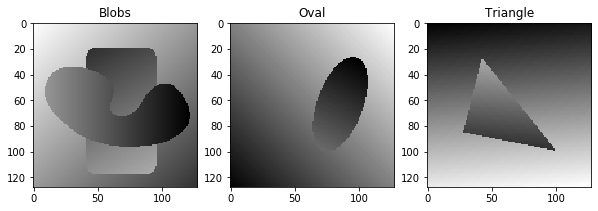

In [7]:
# Read the images in grayscale
blobs = cv2.imread('GradWorld-blobs.jpg', cv2.IMREAD_GRAYSCALE)
oval = cv2.imread('GradWorld-oval.jpg', cv2.IMREAD_GRAYSCALE) 
triangle = cv2.imread('GradWorld-triangle.jpg', cv2.IMREAD_GRAYSCALE)

# Plots the 3 grayscale images
fig, axes = plt.subplots(1,3, figsize=(10, 10))
for img, ax, title in zip([blobs,oval,triangle],
                          axes, 
                          ["Blobs","Oval","Triangle"]):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)

C:\Users\galel\anaconda3\lib\site-packages\ipykernel_launcher.py:44: UserWarning: max_iter was reached


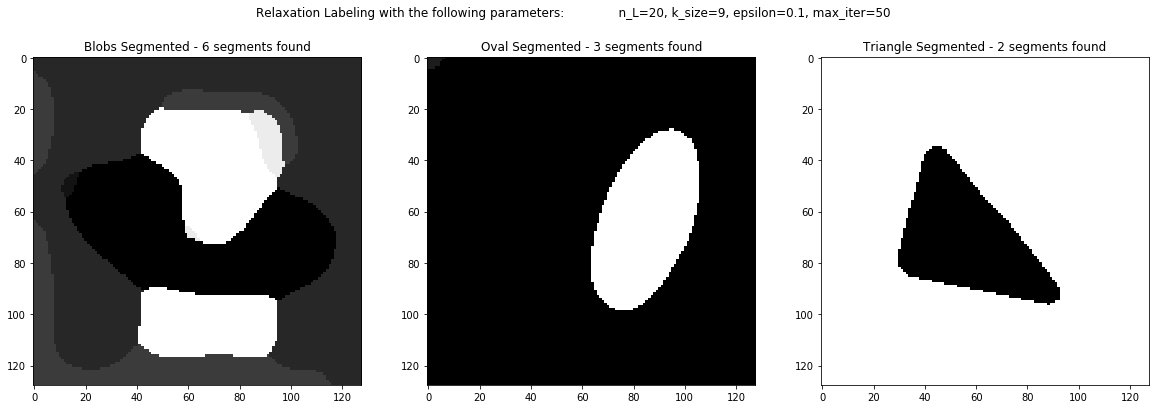

In [8]:
# Use your algorithm to segment the 3 grayscale images
n_L = 20
k_size = 9
epsilon = 0.1
max_iter = 50
segmented_images = [RelaxationLabeling(img, n_L=n_L, k_size=k_size, epsilon=epsilon, max_iter=max_iter) 
                    for img in [blobs, oval, triangle]]
# Plots your results (3 images)
titles = ["Blobs Segmented","Oval Segmented","Triangle Segmented"]
fig, axs = plt.subplots(1,3, figsize=(20, 10))
fig.suptitle(f'Relaxation Labeling with the following parameters: \
             n_L={n_L}, k_size={k_size}, epsilon={epsilon}, max_iter={max_iter}', y=0.8)
for i, ((img, ALCs), title) in enumerate(zip(segmented_images, titles)):
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(title+f' - {np.unique(img).size} segments found')

C:\Users\galel\anaconda3\lib\site-packages\ipykernel_launcher.py:44: UserWarning: max_iter was reached


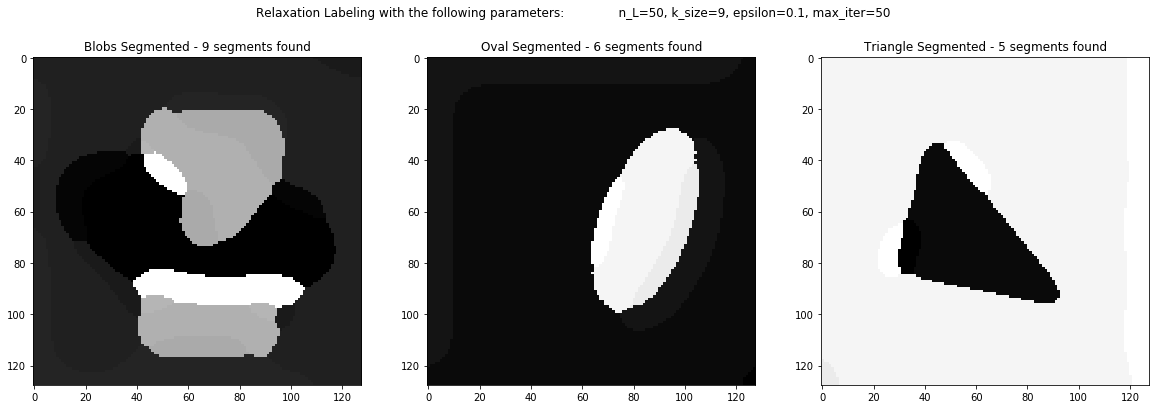

In [9]:
# Use your algorithm to segment the 3 grayscale images
n_L = 50
k_size = 9
epsilon = 0.1
max_iter = 50
segmented_images = [RelaxationLabeling(img, n_L=n_L, k_size=k_size, epsilon=epsilon, max_iter=max_iter) 
                    for img in [blobs, oval, triangle]]
# Plots your results (3 images)
titles = ["Blobs Segmented","Oval Segmented","Triangle Segmented"]
fig, axs = plt.subplots(1,3, figsize=(20, 10))
fig.suptitle(f'Relaxation Labeling with the following parameters: \
             n_L={n_L}, k_size={k_size}, epsilon={epsilon}, max_iter={max_iter}', y=0.8)
for i, ((img, ALCs), title) in enumerate(zip(segmented_images, titles)):
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(title+f' - {np.unique(img).size} segments found')

C:\Users\galel\anaconda3\lib\site-packages\ipykernel_launcher.py:44: UserWarning: max_iter was reached


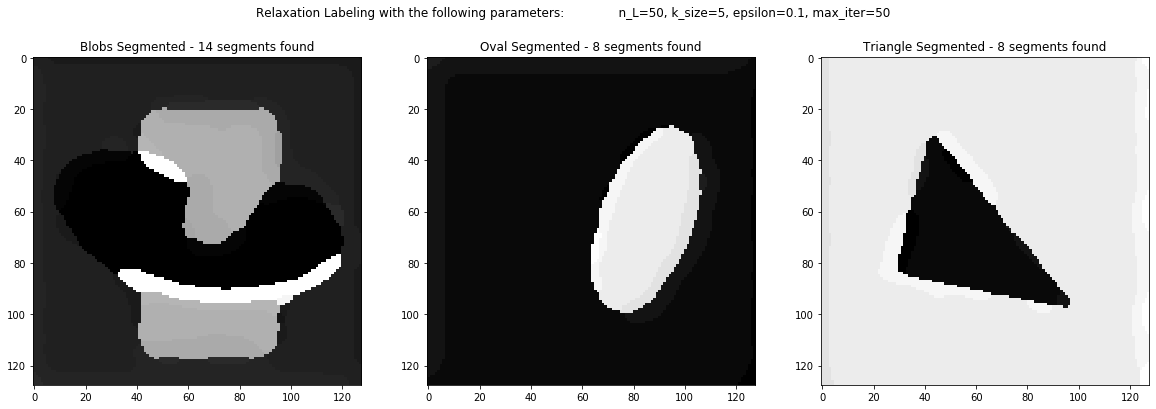

In [10]:
# Use your algorithm to segment the 3 grayscale images
n_L = 50
k_size = 5
epsilon = 0.1
max_iter = 50
segmented_images = [RelaxationLabeling(img, n_L=n_L, k_size=k_size, epsilon=epsilon, max_iter=max_iter) 
                    for img in [blobs, oval, triangle]]
# Plots your results (3 images)
titles = ["Blobs Segmented","Oval Segmented","Triangle Segmented"]
fig, axs = plt.subplots(1,3, figsize=(20, 10))
fig.suptitle(f'Relaxation Labeling with the following parameters: \
             n_L={n_L}, k_size={k_size}, epsilon={epsilon}, max_iter={max_iter}', y=0.8)
for i, ((img, ALCs), title) in enumerate(zip(segmented_images, titles)):
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(title+f' - {np.unique(img).size} segments found')

C:\Users\galel\anaconda3\lib\site-packages\ipykernel_launcher.py:44: UserWarning: max_iter was reached


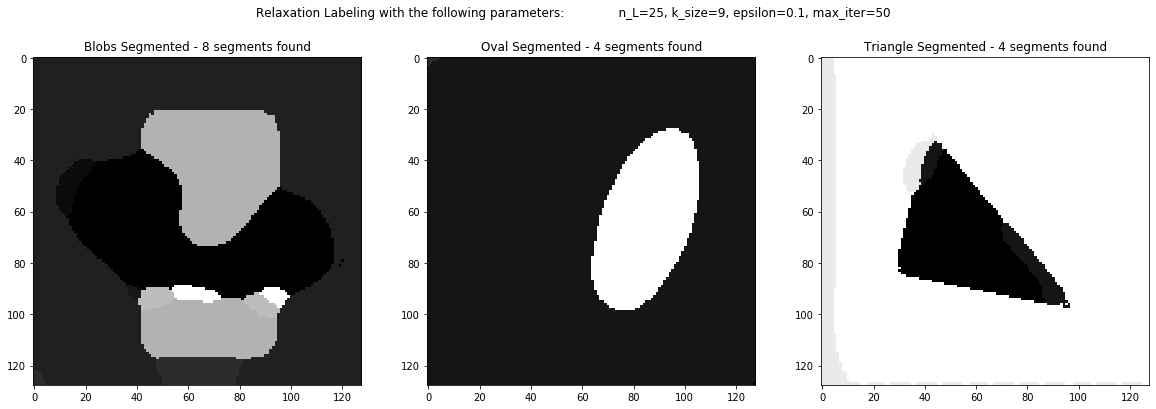

In [11]:
# Use your algorithm to segment the 3 grayscale images
n_L = 25
k_size = 9
epsilon = 0.1
max_iter = 50
segmented_images = [RelaxationLabeling(img, n_L=n_L, k_size=k_size, epsilon=epsilon, max_iter=max_iter) 
                    for img in [blobs, oval, triangle]]
# Plots your results (3 images)
titles = ["Blobs Segmented","Oval Segmented","Triangle Segmented"]
fig, axs = plt.subplots(1,3, figsize=(20, 10))
fig.suptitle(f'Relaxation Labeling with the following parameters: \
             n_L={n_L}, k_size={k_size}, epsilon={epsilon}, max_iter={max_iter}', y=0.8)
for i, ((img, ALCs), title) in enumerate(zip(segmented_images, titles)):
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(title+f' - {np.unique(img).size} segments found')

C:\Users\galel\anaconda3\lib\site-packages\ipykernel_launcher.py:44: UserWarning: max_iter was reached


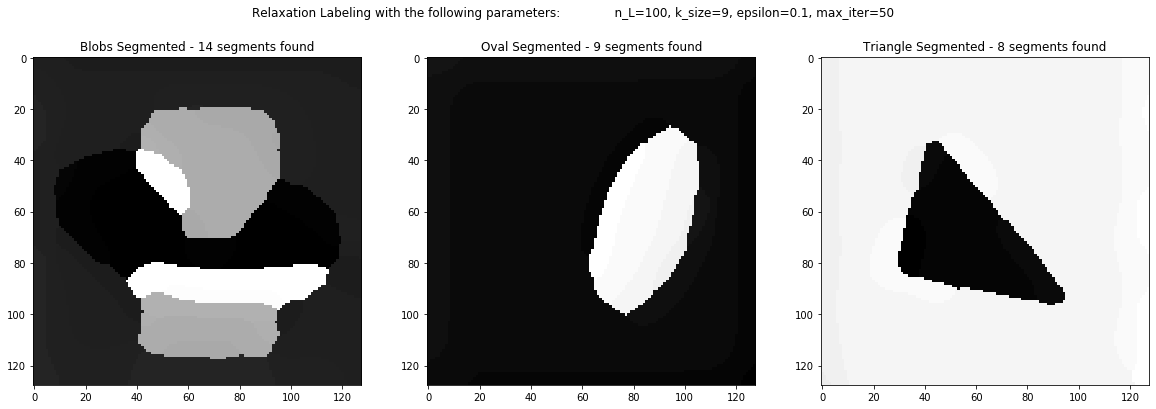

In [12]:
# Use your algorithm to segment the 3 grayscale images
n_L = 100
k_size = 9
epsilon = 0.1
max_iter = 50
segmented_images = [RelaxationLabeling(img, n_L=n_L, k_size=k_size, epsilon=epsilon, max_iter=max_iter) 
                    for img in [blobs, oval, triangle]]
# Plots your results (3 images)
titles = ["Blobs Segmented","Oval Segmented","Triangle Segmented"]
fig, axs = plt.subplots(1,3, figsize=(20, 10))
fig.suptitle(f'Relaxation Labeling with the following parameters: \
             n_L={n_L}, k_size={k_size}, epsilon={epsilon}, max_iter={max_iter}', y=0.8)
for i, ((img, ALCs), title) in enumerate(zip(segmented_images, titles)):
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(title+f' - {np.unique(img).size} segments found')